# Likelihood evaluations for Palanque-Delabrouille et al. (2013)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import mf_emulator
import data_MPGADGET
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import camb_cosmo
import fit_linP
import likelihood
import lya_theory

### Read P1D data from Palanque-Delabrouille et al. (2013)

In [2]:
data=data_MPGADGET.P1D_MPGADGET(filename="1024_L90_mimic.json",z_list=[2.0,3.0,4.0])
#data=data_PD2013.P1D_PD2013(blind_data=True,toy_data=True)
zs=data.z

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [3]:
#basedir='../../p1d_emulator/sim_suites/emulator_512_18062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
basedir='../../p1d_emulator/sim_suites/emulator_256_15072019/'
kmax_Mpc=4.0
p1d_label=None
skewers_label='Ns256_wM0.05'
undersample_z=1
max_arxiv_size=2000
paramList=["Delta2_p","n_p","mF","sigT_Mpc","gamma","kF_Mpc"]
emu_type='mf'
if emu_type is 'linear':
    # specify parameters to emulate
    emulate_slope=True
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                emulate_slope=emulate_slope,emulate_running=emulate_running,
                                emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=False)
elif emu_type=='mf':
    emu=mf_emulator.MeanFluxEmulator(basedir,p1d_label,skewers_label,
                                kmax_Mpc=kmax_Mpc,emu_type='k_bin',
                                max_arxiv_size=None,
                                verbose=True,paramList=paramList,train=True)
else:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,kmax_Mpc=kmax_Mpc,emu_type=emu_type,
                                undersample_z=undersample_z,max_arxiv_size=max_arxiv_size,
                                verbose=True,paramList=paramList,train=True)

0 0.05 0.0 <mf< 0.15000000000000002
1 0.15 0.04999999999999999 <mf< 0.25
2 0.25 0.15 <mf< 0.35
3 0.35 0.24999999999999997 <mf< 0.44999999999999996
4 0.44999999999999996 0.35 <mf< 0.5499999999999999
5 0.5499999999999999 0.44999999999999996 <mf< 0.6499999999999999
6 0.65 0.55 <mf< 0.75
7 0.75 0.65 <mf< 0.85
8 0.85 0.75 <mf< 0.95
9 0.95 0.85 <mf< 1.0
latin hyper-cube data {'param_space': {'Delta2_star': {'ip': 0, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 1, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'heat_amp': {'ip': 2, 'min_val': 0.3, 'max_val': 3.0, 'latex': '$H_A$'}, 'heat_slo': {'ip': 3, 'min_val': -1.5, 'max_val': 1.5, 'latex': '$H_S$'}, 'z_rei': {'ip': 4, 'min_val': 5.5, 'max_val': 16.0, 'latex': '$z_r$'}}, 'nsamples': 50, 'samples': {'0': [0.392, -2.319, 2.757, -0.4500000000000002, 11.905000000000001], '1': [0.268, -2.327, 1.0830000000000002, -1.41, 6.025], '2': [0

 /Users/font/Programs/Others/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!



6750 initial entries
use 353/6750 entries
build emulator 1/10, <F>=0.150
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 353 points
Optimised
6750 initial entries
use 859/6750 entries
build emulator 2/10, <F>=0.250
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 859 points
Optimised
6750 initial entries
use 1221/6750 entries
build emulator 3/10, <F>=0.350
Loading emulator using a specific arxiv, not the one set in basedir
Rescaled params to unity volume
Cannot load emulators with non-standard training data
will train GP emulator
Training GP on 1221 points
Optimised
6750 initial entries
use 1409/6750 entries
build emulator 4/10, <F>=0.450
Loading emulator using a specific arxiv, not the one set in based

### Setup Lyman alpha theory

In [4]:
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=False)

Note: redshifts have been re-sorted (earliest first)


asked to emulate model {'Delta2_p': 0.6300728199380837, 'n_p': -2.2994793220516994, 'alpha_p': -0.2163759661951201, 'f_p': 0.9583552547543478, 'mF': 0.8344581456142232, 'gamma': 1.524949107828223, 'sigT_Mpc': 0.12762905152106743, 'kF_Mpc': 10.214640667246089}
asked to emulate model {'Delta2_p': 0.36031650137680626, 'n_p': -2.2994794594828254, 'alpha_p': -0.21637600594737977, 'f_p': 0.9813695511850136, 'mF': 0.6365, 'gamma': 1.439685410940299, 'sigT_Mpc': 0.12349763773898846, 'kF_Mpc': 12.581594387770235}
asked to emulate model {'Delta2_p': 0.23205325295753354, 'n_p': -2.299479861066885, 'alpha_p': -0.216376343226051, 'f_p': 0.9898232760729386, 'mF': 0.3991063822907449, 'gamma': 1.3768467416640016, 'sigT_Mpc': 0.10804807112864845, 'kF_Mpc': 14.922495585491115}


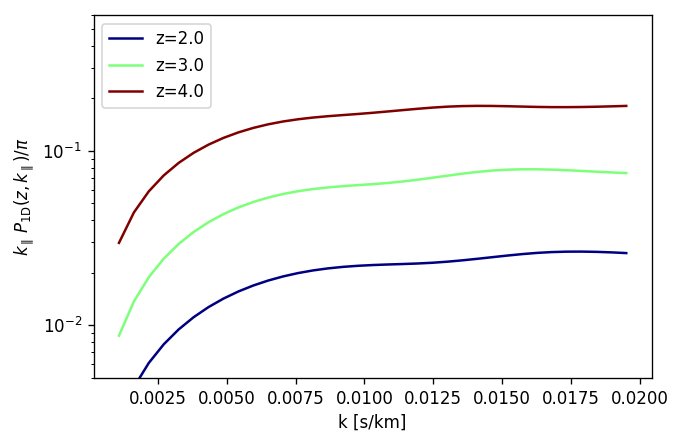

In [5]:
theory.plot_p1d(k_kms=data.k,plot_every_iz=1)

### Compare emulator calls to models in arxiv, for all redhsifts

In [6]:
free_parameters=['ln_tau_0']
min_kp_kms=0.003
prior_Gauss_rms=0.05
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,
                           min_kp_kms=min_kp_kms,prior_Gauss_rms=prior_Gauss_rms)
like.go_silent()

In [7]:
for p in like.free_params: 
    print(p.name,p.value,p.value_in_cube())

ln_tau_0 -0.7945801724139945 0.7054198275860055


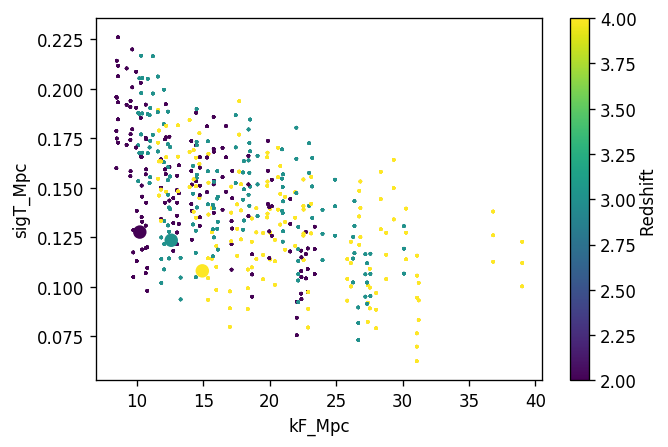

In [8]:
like.overplot_emulator_calls('kF_Mpc','sigT_Mpc')

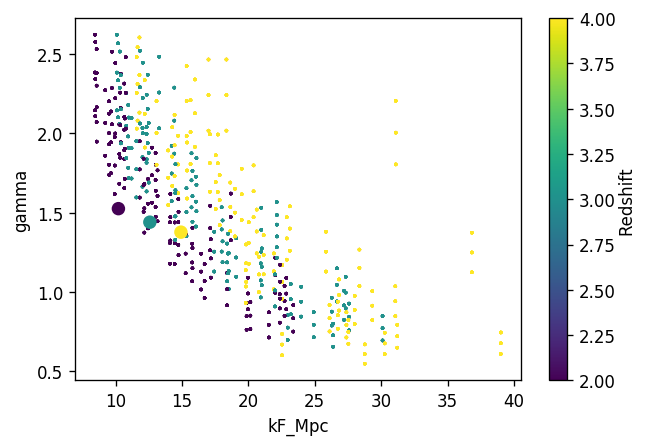

In [9]:
like.overplot_emulator_calls('kF_Mpc','gamma')

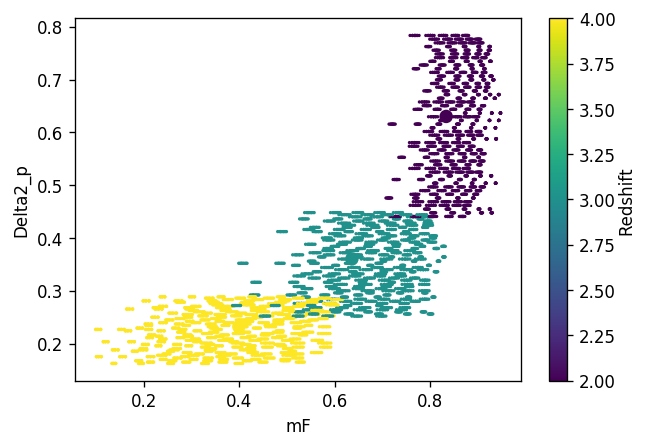

In [10]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=True)

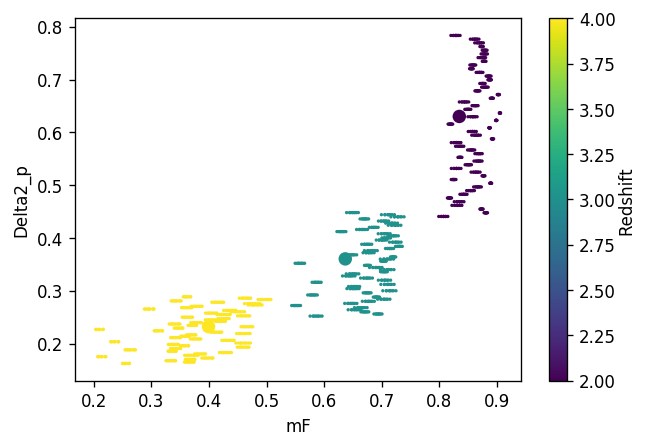

In [11]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=False)

### For each redshift, plot data vs model

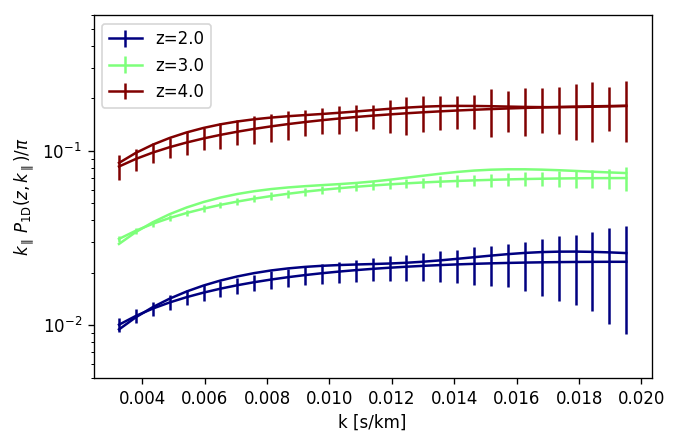

In [12]:
like.plot_p1d(plot_every_iz=1)

### Plot chi2 vs mean optical depth parameter

In [13]:
print('chi2 =',like.get_chi2())

chi2 = 728.4897643187053


In [14]:
# will explore all range of effective optical depth at z=3
value_in_cube=np.linspace(0.0,1.0,200)
Np=len(value_in_cube)
chi2=np.empty(Np)
log_like=np.empty(Np)
log_like_noemu=np.empty(Np)
log_like_nodet=np.empty(Np)
log_like_chi2=np.empty(Np)
log_prob=np.empty(Np)
log_prior=np.empty(Np)
tau0=np.empty(Np)
par=like.free_params[0]
for i in range(Np):
    ln_tau_0=par.value_from_cube(value_in_cube[i])
    tau0[i]=np.exp(ln_tau_0)
    chi2[i] =like.get_chi2(values=[value_in_cube[i]])
    log_like[i]=like.get_log_like(values=[value_in_cube[i]],ignore_log_det_cov=False,add_emu_cov=True)
    log_like_noemu[i]=like.get_log_like(values=[value_in_cube[i]],ignore_log_det_cov=False,add_emu_cov=False)
    log_like_nodet[i]=like.get_log_like(values=[value_in_cube[i]],ignore_log_det_cov=True,add_emu_cov=True)
    log_like_chi2[i]=like.get_log_like(values=[value_in_cube[i]],ignore_log_det_cov=True,add_emu_cov=False)
    log_prob[i]=like.log_prob(values=[value_in_cube[i]])
    log_prior[i]=like.get_log_prior(values=[value_in_cube[i]])
    #print(i,value_in_cube[i],tau0[i],np.exp(-tau0[i]),'chi2 =',chi2[i])

Text(0.5, 0, 'value')

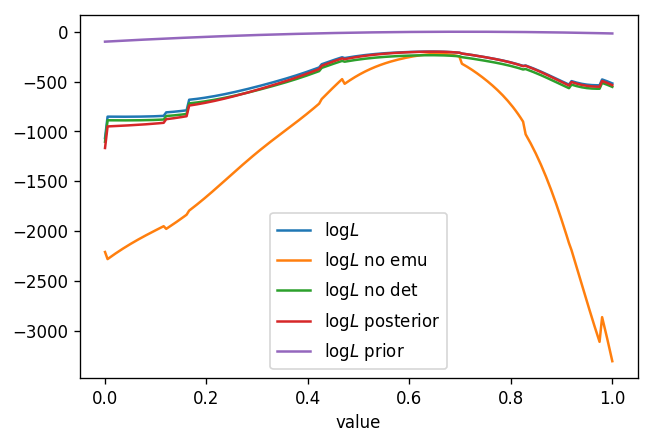

In [15]:
plt.plot(value_in_cube,log_like,label=r'$\log L$')
plt.plot(value_in_cube,log_like_noemu,label=r'$\log L$ no emu')
plt.plot(value_in_cube,log_like_nodet,label=r'$\log L$ no det')
plt.plot(value_in_cube,log_prob,label=r'$\log L$ posterior')
plt.plot(value_in_cube,log_prior,label=r'$\log L$ prior')
plt.legend()
plt.xlabel('value')

Text(0.5, 0, 'value')

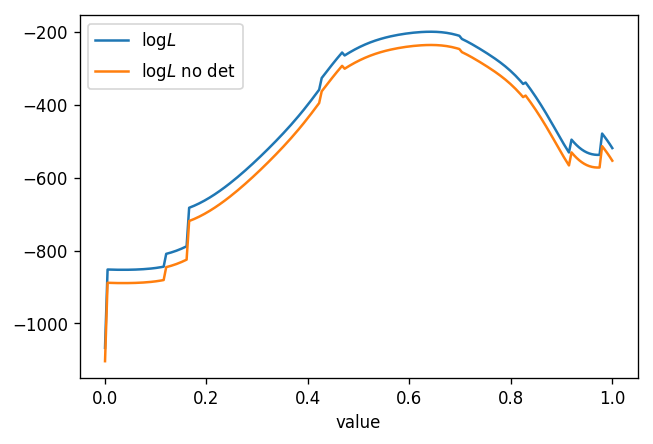

In [16]:
plt.plot(value_in_cube,log_like,label=r'$\log L$')
plt.plot(value_in_cube,log_like_nodet,label=r'$\log L$ no det')
plt.legend()
plt.xlabel('value')

In [17]:
k_kms=data.k
p1d,emu_cov=theory.get_p1d_kms(k_kms=k_kms,return_covar=True)

Text(0, 0.5, '$k_\\parallel \\, P_{\\rm 1D}(z,k_\\parallel) / \\pi$')

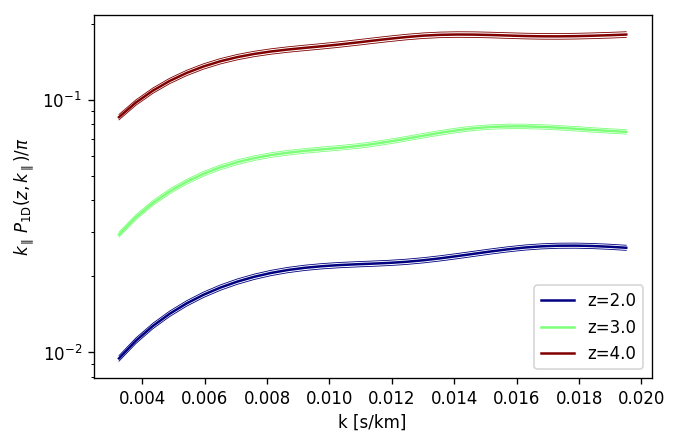

In [18]:
# plot only few redshifts for clarity
Nz=len(zs)
plot_every_iz=1
for iz in range(0,Nz,plot_every_iz):
    # acess data for this redshift
    z=zs[iz]
    p1d_iz=p1d[iz]
    error_iz=np.sqrt(np.diagonal(emu_cov[iz]))
    # plot everything
    col = plt.cm.jet(iz/(Nz-1))
    plt.plot(k_kms,p1d_iz*k_kms/np.pi,color=col,ls='-',label='z=%.1f'%z)
    plt.plot(k_kms,(p1d_iz+error_iz)*k_kms/np.pi,color=col,lw=0.5)
    plt.plot(k_kms,(p1d_iz-error_iz)*k_kms/np.pi,color=col,lw=0.5)

plt.yscale('log')
plt.legend()
plt.xlabel('k [s/km]')
plt.ylabel(r'$k_\parallel \, P_{\rm 1D}(z,k_\parallel) / \pi$')
#plt.ylim(0.005,0.6)

In [19]:
iz=0
data_cov=data.get_cov_iz(iz)
cov=data_cov+emu_cov[iz]

Text(0.5, 1.05, 'Covariance matrix')

<Figure size 960x960 with 0 Axes>

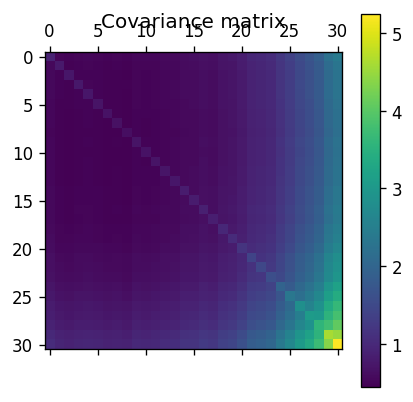

In [20]:
plt.figure(figsize=[8,8])
plt.matshow(cov)
plt.colorbar()
plt.title('Covariance matrix')

Text(0.5, 1.05, 'Emulator covariance matrix')

<Figure size 960x960 with 0 Axes>

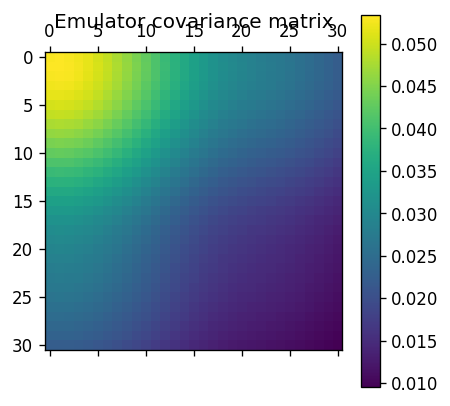

In [21]:
plt.figure(figsize=[8,8])
plt.matshow(emu_cov[iz])
plt.colorbar()
plt.title('Emulator covariance matrix')

Text(0.5, 1.05, 'Data covariance matrix')

<Figure size 960x960 with 0 Axes>

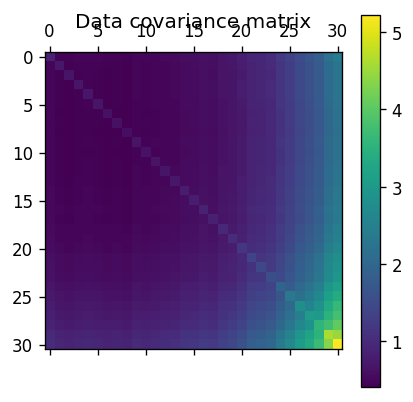

In [22]:
plt.figure(figsize=[8,8])
plt.matshow(data_cov)
plt.colorbar()
plt.title('Data covariance matrix')